In [4]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 18.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Weights and Bias to version the dataset and experiment tracking
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
import wandb

In [7]:
wandb.login()

wandb: Currently logged in as: alokpadhi. Use `wandb login --relogin` to force relogin


True

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import warnings
warnings.filterwarnings("ignore")

In [10]:
import json
import random

In [11]:
!pip install more-itertools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 51 kB 14.5 MB/s eta 0:00:01


In [12]:
import collections
import itertools
from collections import Counter
from more_itertools import take

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam

from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support

In [13]:
SEED = 1234

In [14]:
def set_seeds(seed=1234):
    """set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For multi-gpu

In [15]:
set_seeds(SEED)


In [16]:
cuda = True
device = torch.device("cuda" if(
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")

if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

print(device)

cuda


In [17]:
train_df = pd.read_parquet("../../datasets/V1/train.parquet")
val_df = pd.read_parquet("../../datasets/V1/valid.parquet")
test_df = pd.read_parquet("../../datasets/V1/test.parquet")

<AxesSubplot:ylabel='count'>

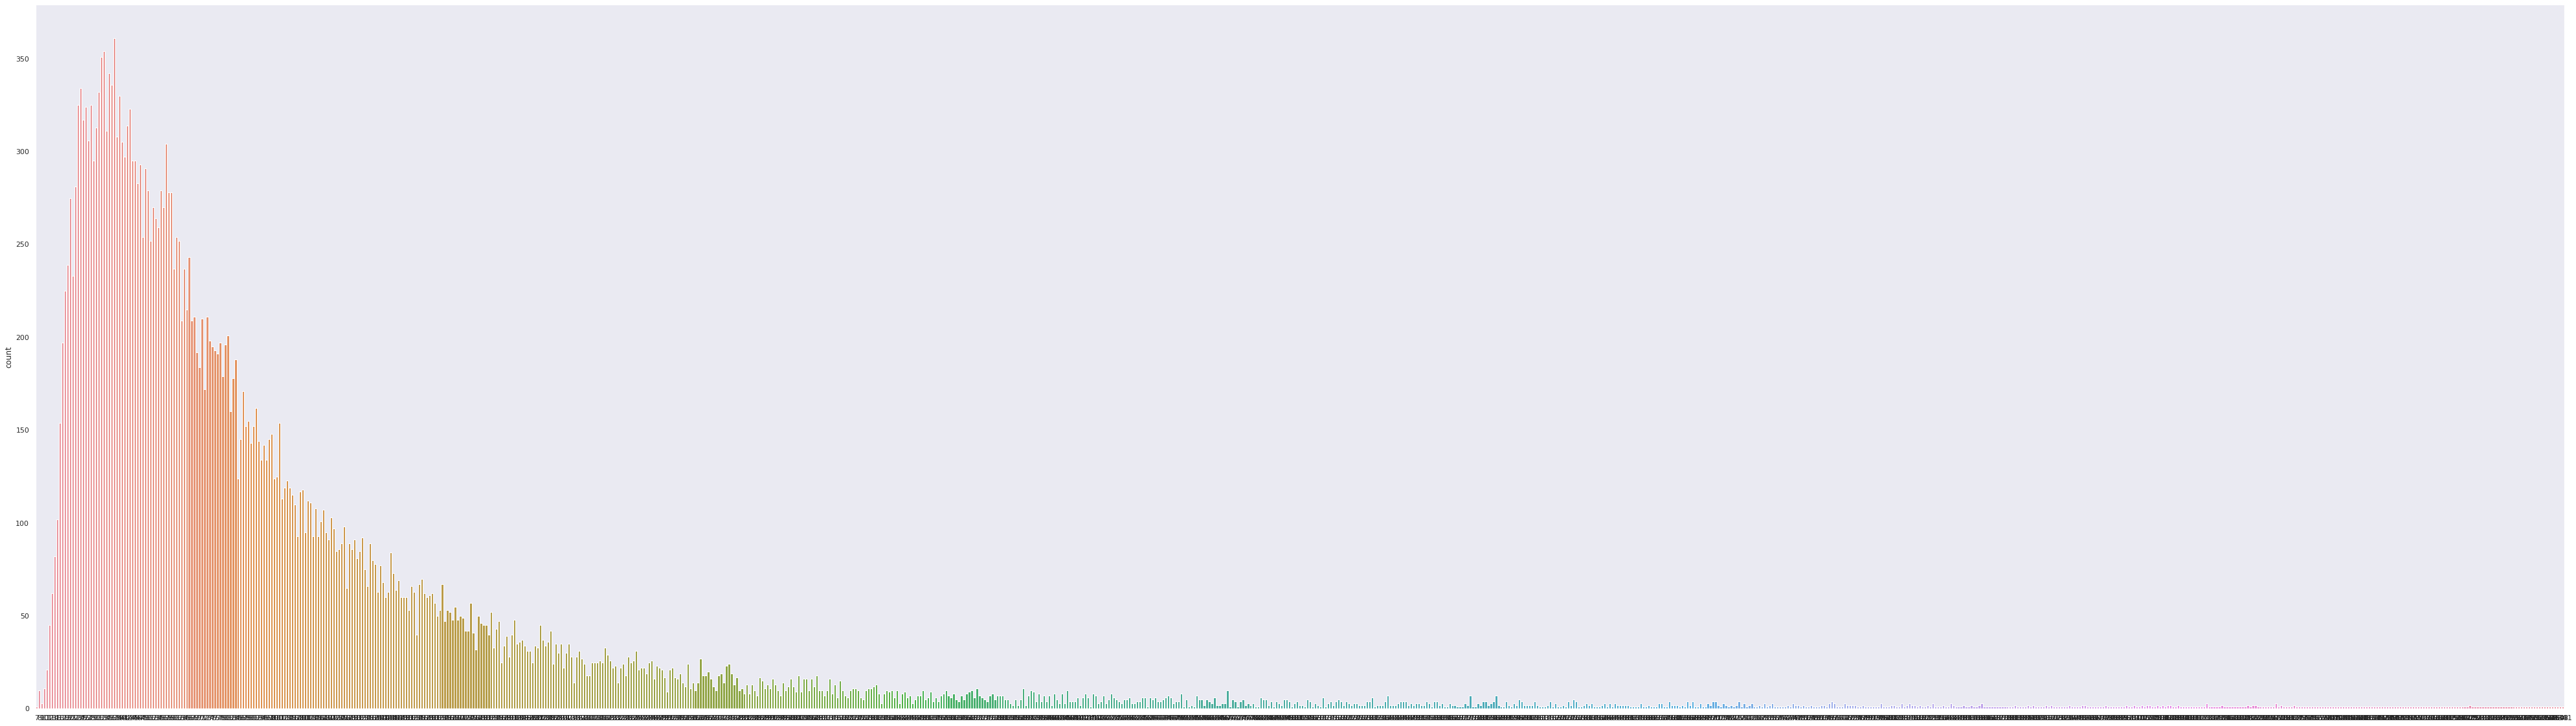

In [18]:
# Sentence length distribution
sent_lengths = sorted([len(sent.split(' ')) for sent in train_df['text'].values], reverse=True)
# print(sent_lengths[:10])
plt.figure(figsize=(70,20))
sns.countplot(sent_lengths)

In [19]:
sent_counter = Counter(sent_lengths).most_common(10)
sent_counter

[(37, 361),
 (33, 354),
 (32, 351),
 (35, 342),
 (36, 336),
 (24, 334),
 (31, 332),
 (39, 330),
 (28, 325),
 (23, 325)]

In [20]:
def suggest_sent_max_length(length_threshold: int=0):
    percentage_sents = [sent for sent in train_df['text'].values if len(sent.split()) > length_threshold]
    print(f"Number of sentences more than length of {length_threshold} are {len(percentage_sents)/len(train_df)*100:.2f}%")

In [21]:
suggest_sent_max_length(200)

Number of sentences more than length of 200 are 10.42%


In [22]:
# Feature and target
X_train = train_df.text.to_numpy()
y_train = train_df.rating

X_val =  val_df.text.to_numpy()
y_val = val_df.rating

X_test = test_df.text.to_numpy()
y_test = test_df.rating

In [23]:
print(f"X_train: {X_train.shape}, y_train:{y_train.shape}")
print(f"X_val: {X_val.shape}, y_val:{y_val.shape}")
print(f"X_test: {X_test.shape}, y_test:{y_test.shape}")

X_train: (31499,), y_train:(31499,)
X_val: (6750,), y_val:(6750,)
X_test: (6751,), y_test:(6751,)


In [24]:
print(f"Sample: {X_train[0]} -> {y_train[0]}")

Sample: python wrong codepython beginner trying execute following 
print( old enough vote please enter age )
input()

age 18

age 18 
 print( must 18 vote )

elif age 18 
 print ( voting age )


run program prints voting age matter low number input someone help sure really basic stuck 

thanks -> LQ_EDIT


In [25]:
# Label encoder to encode class labels
class LabelEncoder(object):
    """Encode labels into unqiue ids/integers"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
    
    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros(len(y), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
    
    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
            
        return classes
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [26]:
label_encoder = LabelEncoder.load("../../artifacts/label_encoder.json")

In [27]:
# Encode all our labels
y_train = label_encoder.encode(y_train)

y_val = label_encoder.encode(y_val)

y_test = label_encoder.encode(y_test)

In [28]:
# Tokenizer
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, pad_token="<PAD>",
                oov_token="<UNK", token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -=2 # pad token and unk token excluded
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v:k for k, v in self.token_to_index.items()}
        
    def __len__(self):
        return len(self.token_to_index)
    
    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"
    
    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(' ') for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]
                ))
            sequences.append(sequence)
        return sequences
            
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(
                    index, self.oov_token
                ))
            texts.append(self.separator.join([token for token in text]))
        return texts
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [29]:
# Check the full vocabulary size of training data
def check_vocab_size(texts):
    texts = [text.split(' ') for text in texts]
    all_tokens = [token for text in texts for token in text]
    # print(len(all_tokens))
    vocab_counts = Counter(all_tokens).most_common(None)
    # print(vocab_counts)
    print(f"Total vocabulary size is: {len(vocab_counts)}")

In [30]:
check_vocab_size(X_train)

Total vocabulary size is: 243250


In [31]:
tokenizer = Tokenizer(char_level=False, num_tokens=200)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(tokenizer)

<Tokenizer(num_tokens=200)>


In [32]:
# Sample
print(take(15, tokenizer.token_to_index.items()))
print(f"Least frequent token's frequency: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK', 1), ('\n', 2), ('\r\n', 3), ('code', 4), ('\n\n', 5), ('gt', 6), ('pre', 7), ('lt', 8), (')', 9), ('0', 10), ('1', 11), ('2', 12), ('\r\n\r\n', 13), ('android', 14)]
Least frequent token's frequency: 2370


In [33]:
tokenizer.save(Path("../../artifacts/tokenizer.json"))

In [34]:
import wandb

In [35]:
wandb.login()

True

In [36]:
token_run = wandb.init(project="stackoverflow-quality", name="Tokenizer")
token_art = wandb.Artifact("Tokenizer", type="preprocessed_data", metadata=dict(num_tokens=200))
token_art.add_file("../../artifacts/tokenizer.json")
token_run.log_artifact(token_art)

In [37]:
# convert texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print("Text to indices: \n"
     f" (Preprocessed) -> {preprocessed_text}\n"
     f" (Tokenized) -> {X_train[0]}")

Text to indices: 
 (Preprocessed) -> python <UNK <UNK <UNK trying <UNK following <UNK <UNK <UNK <UNK please enter <UNK <UNK <UNK <UNK 
 <UNK <UNK <UNK <UNK <UNK <UNK <UNK 
 print ( <UNK <UNK <UNK program <UNK <UNK <UNK <UNK <UNK number input <UNK help <UNK <UNK <UNK <UNK <UNK
 (Tokenized) -> [93, 1, 1, 1, 72, 1, 88, 1, 1, 1, 1, 95, 103, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 188, 22, 1, 1, 1, 164, 1, 1, 1, 1, 1, 75, 62, 1, 53, 1, 1, 1, 1, 1]


In [38]:
def to_categorical(seq, num_classes):
    """One-hot encode sequence of tokens"""
    one_hot = np.zeros((len(seq), num_classes))
    for i, item in enumerate(seq):
        one_hot[i, item] = 1
    return one_hot

In [39]:
print(X_train[0])
print(len(X_train[0]))
cat = to_categorical(seq=X_train[0], num_classes=len(tokenizer))
print(cat)
print(cat.shape)

[93, 1, 1, 1, 72, 1, 88, 1, 1, 1, 1, 95, 103, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 188, 22, 1, 1, 1, 164, 1, 1, 1, 1, 1, 75, 62, 1, 53, 1, 1, 1, 1, 1]
46
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(46, 200)


In [40]:
vocab_size = len(tokenizer)
X_train = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_train]
X_val = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_val]
X_test = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_test]

In [41]:
# Pad the sequences to max_length
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max_length in sequence"""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    num_classes = sequences[0].shape[-1]
    padded_sequences = np.zeros((len(sequences), max_seq_len, num_classes))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [42]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
padded = pad_sequences(X_train[0:3])
print(padded.shape)

(46, 200) (102, 200) (80, 200)
(3, 102, 200)


In [43]:
FILTER_SIZE = 1 # Unigram, we can try bigram and trigram as well

In [44]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size
        
    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]
    
    def collate_fn(self, batch):
        batch = np.array(batch)
        X = batch[:, 0]
        y = batch[:, 1]
        
        X = pad_sequences(X, max_seq_len=self.max_filter_size)
        
        X = torch.FloatTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))
        
        return X, y
    
    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True
        )

In [45]:
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=FILTER_SIZE)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=FILTER_SIZE)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=FILTER_SIZE)

In [46]:
print("Dasets: \n"
     f"Train Dataset: {train_dataset.__str__()}\n"
     f"Val Dataset: {val_dataset.__str__()}\n"
     f"Test Dataset: {test_dataset.__str__()}\n"
     f"Sample Data:\n"
     f"X: {train_dataset[0][0]}\n"
     f"y {train_dataset[0][1]}")

Dasets: 
Train Dataset: <Dataset(N=31499)>
Val Dataset: <Dataset(N=6750)>
Test Dataset: <Dataset(N=6751)>
Sample Data:
X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
y 2


In [47]:
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

In [48]:
batch_X, batch_y = next(iter(train_dataloader))
print("Sample batch:\n"
     f"X: {list(batch_X.size())}\n"
     f"y: {list(batch_y.size())}\n"
     f"Sample point: \n"
     f"X: {batch_X[0]}\n"
     f"y: {batch_y[0]}")

Sample batch:
X: [64, 1474, 200]
y: [64]
Sample point: 
X: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cpu')
y: 2


In [49]:
NUM_FILTERS = 50
HIDDEN_DIM = 128
DROPOUT_P = 0.1
NUM_CLASSES = len(label_encoder)

In [50]:
NUM_CLASSES

3

In [51]:
class CNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                hidden_dim, dropout, num_classes):
        super(CNN, self).__init__()
        
        self.filter_size = filter_size
        self.conv = nn.Conv1d(
            in_channels=vocab_size, out_channels=num_filters,
            kernel_size=filter_size, stride=1, padding=0, padding_mode="zeros"
        )
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)
        
        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, inputs, channel_first=False):
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2)
        
        # "SAME" padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))
        
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))
        z = F.max_pool1d(z, z.size(2)).squeeze(2)
        
        
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        
        return z

In [52]:
model = CNN(vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
            hidden_dim=HIDDEN_DIM, dropout=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (conv): Conv1d(200, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)>


In [53]:
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 50

In [62]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    def train_step(self, dataloader):
        self.model.train()
        loss = 0.0
        
        # iterate over batches
        for i, batch in enumerate(dataloader):
            batch = [item.to(device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()
            z = self.model(inputs)
            J = self.loss_fn(z, targets)
            J.backward()
            self.optimizer.step()
            
            loss += (J.detach().item() - loss) / (i+1)
        return loss
    
    def eval_step(self, dataloader):
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []
        
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):
                batch = [item.to(device) for item in batch]
                inputs, y_true = batch[:-1], batch[-1]
                
                z = self.model(inputs)
                J = self.loss_fn(z, y_true).item()
                
                loss += (J - loss) / (i + 1)
                
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())
                
            
            return loss, np.vstack(y_trues), np.vstack(y_probs)
        
    def predict_step(self, dataloader):
        self.model.eval()
        y_probs = []
        
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):
                inputs, targets = batch[:-1], batch[-1]
                
                z = self.model(inputs)
                
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
            return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloder, val_dataloader, wandb_run):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            print(f"[INFO] Epoch: {epoch+1} training started")
            train_loss = self.train_step(dataloader=train_dataloader)
            print(f"[INFO] Epoch: {epoch+1} training finished")
            print(f"[INFO] Epoch: {epoch+1} evaluation started")
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            print(f"[INFO] Epoch: {epoch+1} evaluation finished")
            self.scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                wandb_run.summary["Best val loss"] = best_val_loss
                _patience = patience
            else:
                _patience -= 1
            
            if not _patience:
                print("Stopping Early")
                break
            print(f"[INFO] Logging wandb")
            wandb.log({"train_loss": train_loss})
            wandb.log({"valid_loss": val_loss})
            
            print(
                f"Epoch: {epoch+1}\n"
                f"\t train_loss: {train_loss:.3f}, "
                f"\t val_loss: {val_loss: .3f}, "
                f"\t LR: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [63]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\n weights: {class_weights}")

counts: [10499 10500 10500]
 weights: {0: 9.524716639679969e-05, 1: 9.523809523809524e-05, 2: 9.523809523809524e-05}


In [64]:
# loss function
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [65]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

In [66]:
CONFIG = dict(
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    epochs=NUM_EPOCHS,
    target_classes=NUM_CLASSES,
    optimizer="Adam",
    scheduler="ReduceLROnPlateau",
    loss_function="Cross Entropy",
    model="CNN",
)

In [69]:
run = wandb.init(project="stackoverflow-quality", config=CONFIG, name="CNN")

In [70]:
trainer = Trainer(model=model, device=device, loss_fn=loss_fn,
                 optimizer=optimizer, scheduler=scheduler)

In [71]:
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader, run
)

[INFO] Epoch: 1 training started
[INFO] Epoch: 1 training finished
[INFO] Epoch: 1 evaluation started
[INFO] Epoch: 1 evaluation finished
[INFO] Logging wandb
Epoch: 1
	 train_loss: 0.410, 	 val_loss:  0.427, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 2 training started
[INFO] Epoch: 2 training finished
[INFO] Epoch: 2 evaluation started
[INFO] Epoch: 2 evaluation finished
[INFO] Logging wandb
Epoch: 2
	 train_loss: 0.407, 	 val_loss:  0.427, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 3 training started
[INFO] Epoch: 3 training finished
[INFO] Epoch: 3 evaluation started
[INFO] Epoch: 3 evaluation finished
[INFO] Logging wandb
Epoch: 3
	 train_loss: 0.404, 	 val_loss:  0.426, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 4 training started
[INFO] Epoch: 4 training finished
[INFO] Epoch: 4 evaluation started
[INFO] Epoch: 4 evaluation finished
[INFO] Logging wandb
Epoch: 4
	 train_loss: 0.402, 	 val_loss:  0.426, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 5 training started
[INFO] Epoch: 5

In [72]:
model_artifact = Path("../../model-artifacts/")

In [74]:
# save the model
torch.save(best_model.state_dict(), Path(model_artifact, "cnn-model.pt"))

In [75]:
# model version
# model versioning
model_art = wandb.Artifact(f"{wandb.run.name}_{wandb.run.id}", type="model", metadata=CONFIG)
model_art.add_file("../../model-artifacts/cnn-model.pt")
run.log_artifact(model_art)

In [76]:
def get_metrics(y_true, y_pred, classes):
    performance = {"overall": {}, "class": {}}
    
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1-score"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))
    
    # Per-class performance
    class_metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": class_metrics[0][i],
            "recall": class_metrics[1][i],
            "f1-score": class_metrics[2][i],
            "num_samples": np.float64(class_metrics[3][i]),
        }
        
    return performance

In [77]:
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [78]:
performance = get_metrics(y_true, y_pred, classes=label_encoder.classes)
print(json.dumps(performance["overall"], indent=2))

{
  "precision": 0.8019811419194605,
  "recall": 0.8034365279217893,
  "f1-score": 0.8026285629154619,
  "num_samples": 6751.0
}


In [79]:
run.log({"precision": performance["overall"]["precision"], "recall": performance["overall"]["recall"], "f1-score": performance["overall"]["f1-score"]})

In [80]:
wandb.finish()

f1-score,▁
precision,▁
recall,▁
train_loss,█▇▆▆▆▅▅▅▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁
valid_loss,██▇▇█▇▇█▇██▁▁▁▁▂▁▁▁▁▁▁▁
Best val loss,0.41859
f1-score,0.80263
precision,0.80198
recall,0.80344
train_loss,0.38101
valid_loss,0.41862
